In [1]:
import glob
import math
import pathlib
import subprocess

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from IPython import display

## Video Reading & Converting

In [2]:
file_name = "0000f77c-6257be58"
in_path = f"data/{file_name}.mov"
out_path = f"data/{file_name}.mp4"

if not pathlib.Path(out_path).exists():
    subprocess.run(["ffmpeg", "-i", in_path, out_path])

In [3]:
display.Video(out_path, width=640, height=480)

In [4]:
video_capture = cv.VideoCapture(out_path)

print("FPS:    ", video_capture.get(cv.CAP_PROP_FPS))
print("Frames: ", video_capture.get(cv.CAP_PROP_FRAME_COUNT))

FPS:     29.97002997002997
Frames:  1211.0


In [5]:
height = video_capture.get(cv.CAP_PROP_FRAME_HEIGHT)
width = video_capture.get(cv.CAP_PROP_FRAME_WIDTH)

print("Height: ", height)
print("Width:  ", width)

Height:  720.0
Width:   1280.0


## Getting Video Frames

In [6]:
ret, img = video_capture.read()
img_shape = img.shape
print(f"Returned {ret} and image of shape {img.shape}")

Returned True and image of shape (720, 1280, 3)


In [7]:
def show_cv_image(img):
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

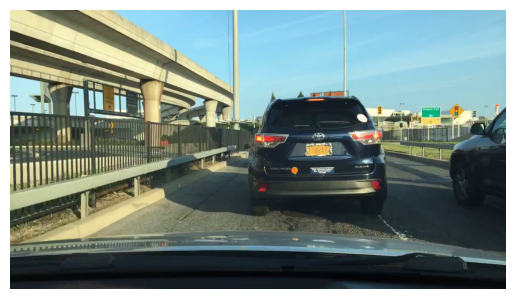

In [8]:
show_cv_image(img)
video_capture.release()

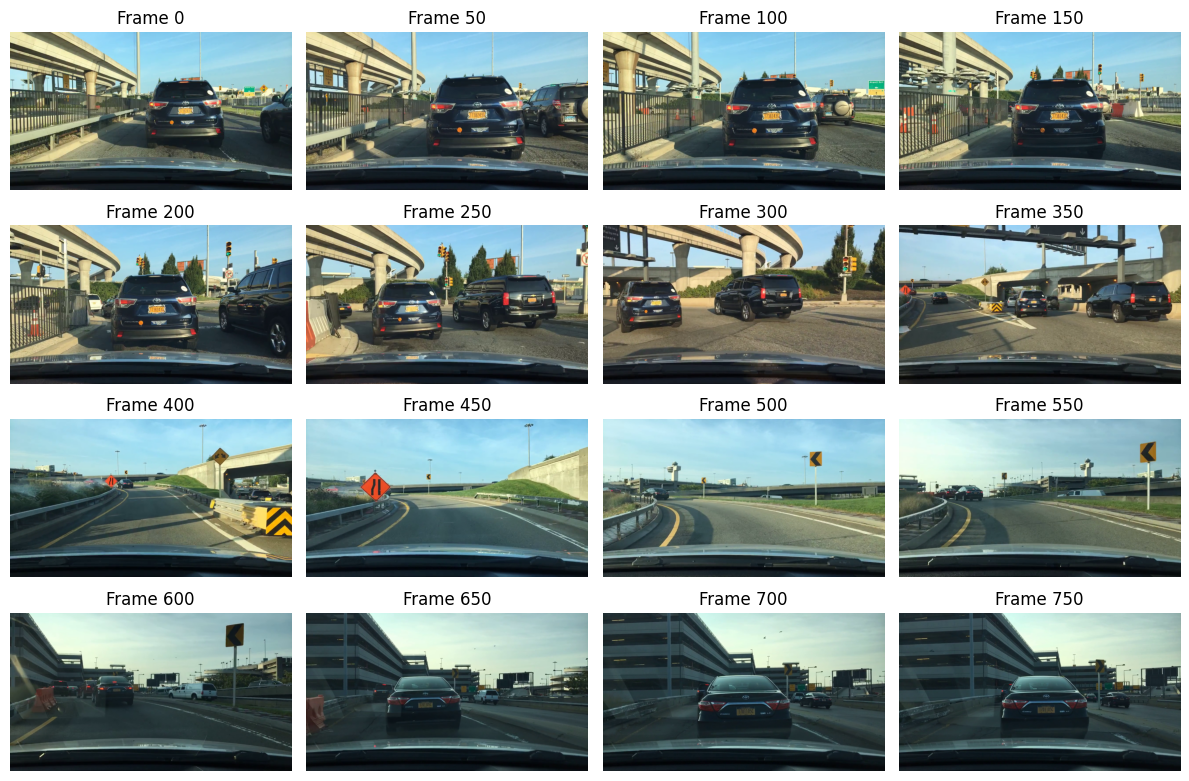

In [9]:
video_capture = cv.VideoCapture(out_path)
fps = video_capture.get(cv.CAP_PROP_FPS)
n_frames = int(video_capture.get(cv.CAP_PROP_FRAME_COUNT))

grid = (4, 4)
fig, axes = plt.subplots(*grid, figsize=(12, 8), tight_layout=True)
axes = axes.flatten()
images = math.prod(grid)
img_idx = 0

for frame in range(n_frames):
    ret, img = video_capture.read()
    if not ret:
        break
    if frame % 50 == 0 and img_idx < images:
        axes[img_idx].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
        axes[img_idx].set_title(f"Frame {frame}")
        axes[img_idx].axis("off")
        img_idx += 1

plt.show()
video_capture.release()

## Setting Boxes

In [10]:
if not pathlib.Path("data/mot_labels.parquet").exists():
    pl.scan_csv("data/mot_labels.csv").filter(pl.col("videoName") == file_name).collect().write_parquet(
        "data/mot_labels.parquet"
    )

video_labels = pl.read_parquet("data/mot_labels.parquet")
video_labels.head()

name,videoName,frameIndex,id,category,attributes.crowd,attributes.occluded,attributes.truncated,box2d.x1,box2d.x2,box2d.y1,box2d.y2,haveVideo
str,str,i64,i64,str,bool,bool,bool,f64,f64,f64,f64,bool
"""0000f77c-6257b…","""0000f77c-6257b…",0,37555,"""car""",false,false,false,611.833856,973.212667,213.771711,532.72072,true
"""0000f77c-6257b…","""0000f77c-6257b…",0,37556,"""car""",false,false,true,1129.592001,1278.674291,248.109076,516.457198,true
"""0000f77c-6257b…","""0000f77c-6257b…",1,37555,"""car""",false,false,false,609.318047,977.532372,211.411012,532.72072,true
"""0000f77c-6257b…","""0000f77c-6257b…",1,37556,"""car""",false,false,true,1130.360726,1278.674291,247.964932,518.760884,true
"""0000f77c-6257b…","""0000f77c-6257b…",2,37555,"""car""",false,false,false,577.759081,994.127314,198.340717,562.503975,true


In [11]:
freq = 5  # 5 mot_labels.csv is labeled at 5 Hz
video_labels = video_labels.with_columns(
    videoFrame=(pl.col("frameIndex") * fps / freq).round().cast(pl.Int32)
)
video_labels.head()

name,videoName,frameIndex,id,category,attributes.crowd,attributes.occluded,attributes.truncated,box2d.x1,box2d.x2,box2d.y1,box2d.y2,haveVideo,videoFrame
str,str,i64,i64,str,bool,bool,bool,f64,f64,f64,f64,bool,i32
"""0000f77c-6257b…","""0000f77c-6257b…",0,37555,"""car""",false,false,false,611.833856,973.212667,213.771711,532.72072,true,0
"""0000f77c-6257b…","""0000f77c-6257b…",0,37556,"""car""",false,false,true,1129.592001,1278.674291,248.109076,516.457198,true,0
"""0000f77c-6257b…","""0000f77c-6257b…",1,37555,"""car""",false,false,false,609.318047,977.532372,211.411012,532.72072,true,6
"""0000f77c-6257b…","""0000f77c-6257b…",1,37556,"""car""",false,false,true,1130.360726,1278.674291,247.964932,518.760884,true,6
"""0000f77c-6257b…","""0000f77c-6257b…",2,37555,"""car""",false,false,false,577.759081,994.127314,198.340717,562.503975,true,12


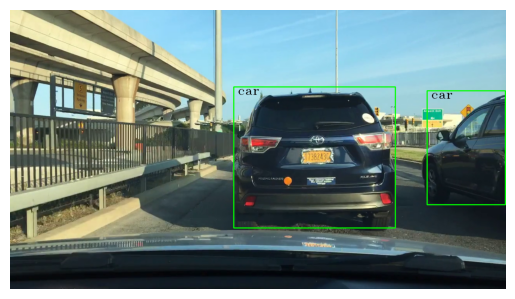

In [12]:
video_capture = cv.VideoCapture(out_path)
n_frames = int(video_capture.get(cv.CAP_PROP_FRAME_COUNT))
frame_to_show = 12
video_capture.set(cv.CAP_PROP_POS_FRAMES, frame_to_show)
ret, img = video_capture.read()
img_cp = img.copy()

frame_labels = video_labels.filter(pl.col("videoFrame") == frame_to_show)
for row in frame_labels.iter_rows(named=True):
    pt1 = (int(row["box2d.x1"]), int(row["box2d.y1"]))
    pt2 = (int(row["box2d.x2"]), int(row["box2d.y2"]))
    pt_text = (int(row["box2d.x1"]) + 10, int(row["box2d.y1"]) + 20)
    cv.rectangle(img_cp, pt1, pt2, color=(0, 255, 0), thickness=2)
    cv.putText(img_cp, row["category"], pt_text, cv.FONT_HERSHEY_TRIPLEX, 1, (0, 0, 0))

show_cv_image(img_cp)

## Full Video with Boxes

In [13]:
def add_annotation(img, frame, video_labels):
    img_cp = img.copy()
    # frame_labels = video_labels.filter(pl.col("videoFrame") == frame)
    max_frame = video_labels.filter(pl.col("videoFrame") <= frame)["videoFrame"].max()
    frame_labels = video_labels.filter(pl.col("videoFrame") == max_frame)
    for row in frame_labels.iter_rows(named=True):
        x1, y1 = (int(row["box2d.x1"]), int(row["box2d.y1"]))
        x2, y2 = (int(row["box2d.x2"]), int(row["box2d.y2"]))
        cv.rectangle(img_cp, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2)

        label = row["category"]
        (w, h), _ = cv.getTextSize(label, cv.FONT_HERSHEY_SIMPLEX, 1.5, 2)
        cv.rectangle(img_cp, (x1, y1 - h), (x1 + w, y1), (0, 255, 0), -1)
        cv.putText(img_cp, label, (x1 + 10, y1 - 10), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)

    return img_cp

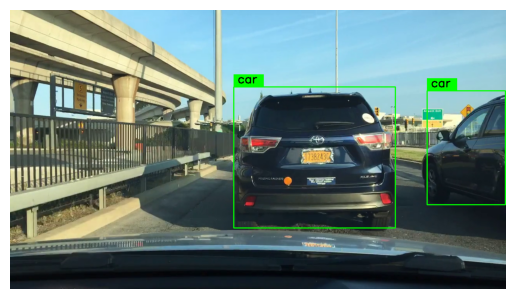

In [14]:
video_capture = cv.VideoCapture(out_path)
n_frames = int(video_capture.get(cv.CAP_PROP_FRAME_COUNT))
frame_to_show = 12
video_capture.set(cv.CAP_PROP_POS_FRAMES, frame_to_show)
ret, img = video_capture.read()
img_cp = add_annotation(img, frame_to_show, video_labels)
show_cv_image(img_cp)

In [15]:
video_capture = cv.VideoCapture(out_path)
n_frames = int(video_capture.get(cv.CAP_PROP_FRAME_COUNT))

video_codec = "mp4v"
fps = video_capture.get(cv.CAP_PROP_FPS)
width = int(video_capture.get(cv.CAP_PROP_FRAME_WIDTH))
height = int(video_capture.get(cv.CAP_PROP_FRAME_HEIGHT))

video_out = cv.VideoWriter("data/out_video.mp4", cv.VideoWriter.fourcc(*video_codec), fps, (width, height))
for frame in range(n_frames):
    ret, img = video_capture.read()
    if not ret:
        break
    img = add_annotation(img, frame, video_labels)
    video_out.write(img)

video_capture.release()
video_out.release()

In [16]:
tmp_output_path = "data/out_video.mp4"
output_path = "data/out_video_compressed.mp4"
prompt = f"ffmpeg -i {tmp_output_path} {output_path} -loglevel quiet"
subprocess.run(list(prompt.split(" ")))

CompletedProcess(args=['ffmpeg', '-i', 'data/out_video.mp4', 'data/out_video_compressed.mp4', '-loglevel', 'quiet'], returncode=0)

In [17]:
display.Video(output_path, width=640, height=480)